# **AIML Online Capstone - Pneumonia Detection Challenge:**

**What is Pneumonia?**

Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.

Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or postradiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.

**Pneumonia Detection**

Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**Business Domain Value:**

Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box.

Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).
Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

**Project Description:**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

Details about the data and dataset files are given in below link,

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data


In [5]:
# loading the necessary libraries

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches
import math
import pydicom as dcm

#Initialize the random number generator
import random as rd
rd.seed(0)
#Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
from glob import glob

# from google.colab import drive  # import drive from google colab
# drive.mount('/content/drive',force_remount=True)  # default location for the drive
# os.chdir("/content/drive/My Drive/CV/CapstoneProject/") # we mount the google drive at /content/drive and change dir to this

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.applications.mobilenet import preprocess_input

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D

In [6]:
os.chdir("/Users/seenu/tensorflow/rsna-pneumonia-detection-challenge/")

In [7]:
#os.chdir("C:/Users\\Naveen_G\\My_Projects\\Capstone")

In [8]:
# Reading the train labels dataset and showing first 5 records of this train labels
data= pd.read_csv ("stage_2_train_labels.csv")
data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


#Insights of info: 

*    Train dataset comprises of 30227 patients details but coordinates of bounding boxes are given

*   Only for 9555 patients

*    Hence remaining are considered as null values



In [10]:
data.shape

(30227, 6)

In [11]:
# Detecting missing values

data.isnull().sum()

# below data reflects that 20672 chest x rays having null values and dont have any bounding boxes 

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [12]:
# counting the Target those having chest X rays with out bounding boxes 

data[data.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [13]:
# counting the Target those having chest X rays with bounding boxes

data[~data.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [14]:
data[data.isnull().any(axis=1)]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


# insights of null values: 

*   It has been found that 20672 patients with target 0- dont have pnemonia (chest X rays with out bounding boxes)

*   9555 patients with target 1- having pnemonia (chest X rays with bounding boxes)



In [15]:
# checking if there are unique values of patient ID

data["patientId"].is_unique

False

In [16]:
# checking the duplicate patient ids because corrdinates of bounding boxes might be duplicates

data["patientId"].duplicated().sum()

3543

In [17]:
duplicatept= data[data["patientId"].duplicated()]

In [18]:
duplicatept.head(5)

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1


In [19]:
# checking the duplicate patient ID has how many bounding boxes

data[data.patientId=="00704310-78a8-4b38-8475-49f4573b2dbb"]

,patientId,x,y,width,height,Target
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [20]:
data[data.patientId=="00c0b293-48e7-4e16-ac76-9269ba535a62"]

,patientId,x,y,width,height,Target
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1


  <b> 

*   From the above examples, it indicates that same patient has 2 bounding boxes in their DICOM images



In [21]:
# checking the count of Target column
data.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [22]:
# Reading the detailed class info

det_class= pd.read_csv(("stage_2_detailed_class_info.csv"))
det_class.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [23]:
# checking the shape
det_class.shape

(30227, 2)

In [24]:
# checking the info
det_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [25]:
# checking the null values
det_class.isnull().sum()

patientId    0
class        0
dtype: int64

In [26]:
# checking the duplicate values

det_class.patientId.duplicated().sum()

3543

* <b>it indicates that same number of patient ID s are duplicate as like in train label dataset

In [27]:
# checking the duplicate patients 
duplicate_class= det_class[det_class.patientId.duplicated()]
duplicate_class.head(5)

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity


In [28]:
# checking the duplicate patients with their respective classes

det_class[det_class.patientId=="00704310-78a8-4b38-8475-49f4573b2dbb"]

,patientId,class
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [29]:
det_class[det_class.patientId=="00c0b293-48e7-4e16-ac76-9269ba535a62"]

,patientId,class
16,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity


In [30]:
# checking the count of class column

det_class["class"].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


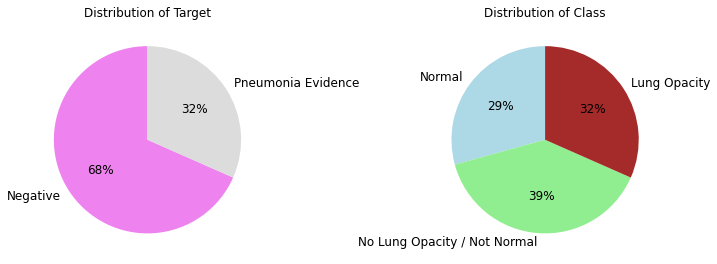

In [31]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (data['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['violet', 'gainsboro'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (det_class['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['lightblue', 'lightgreen', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()


In [32]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*44)
b_boxes = data[~data.isnull().any(axis=1)].groupby('patientId').size().to_frame('number_of_boxes').reset_index()

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
----------------------------------------------------------------------------------------


In [33]:
b_boxes

,patientId,number_of_boxes
0,000db696-cf54-4385-b10b-6b16fbb3f985,2
1,000fe35a-2649-43d4-b027-e67796d412e0,2
2,001031d9-f904-4a23-b3e5-2c088acd19c6,2
3,001916b8-3d30-4935-a5d1-8eaddb1646cd,1
4,0022073f-cec8-42ec-ab5f-bc2314649235,2
...,...,...
6007,ffa424d2-6e6b-4eed-93ab-7551e8941215,2
6008,ffae40ab-fcfe-4311-a74a-89f605dba48b,1
6009,ffd787b6-59ca-48cb-bd15-bcedd52cf37c,2
6010,fff0b503-72a5-446a-843d-f3d152e39053,1


In [34]:
data_df = b_boxes.merge(b_boxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(b_boxes)))
print('\nNumber of patient IDs per b_boxes in the train dataset')
(b_boxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))


Number of unique patient IDs in the dataset: 6012

Number of patient IDs per b_boxes in the train dataset


,number_of_patientIDs_per_boxes
number_of_boxes,
1,2614
2,3266
3,119
4,13


In [35]:
#sorting both the datasets based on patientId
data.sort_values('patientId', inplace = True)
det_class.sort_values('patientId', inplace = True)

In [36]:
#concatenating the data labels and class labels file for model training
train_data = pd.concat([data, det_class['class']], axis = 1, sort = False)
print('The merged dataset has {} rows and {} columns and looks like:'.format(train_data.shape[0], train_data.shape[1]))
train_data.head()

The merged dataset has 30227 rows and 7 columns and looks like:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


In [37]:
# analysing the stage 2 train images (DICOM format)
import pydicom as dcm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches


def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

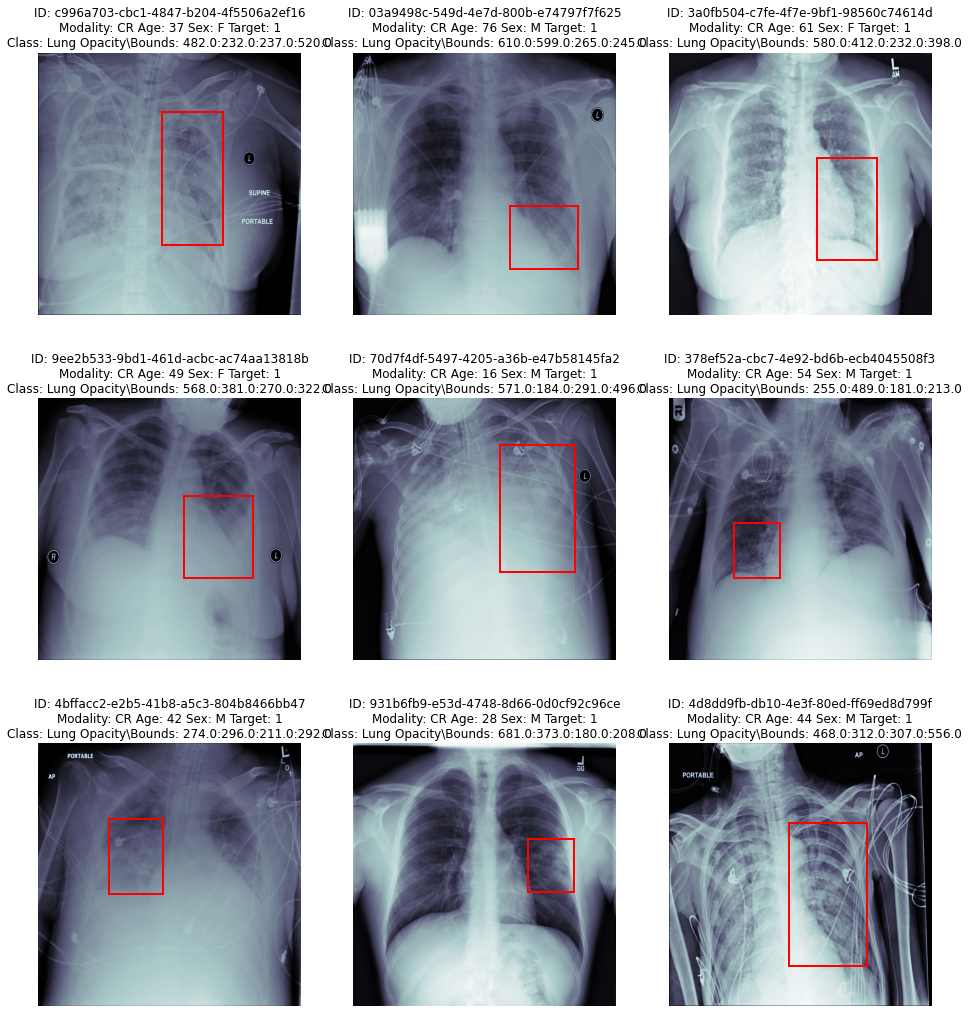

In [38]:
## checking few images which has pneumonia 

inspectImages(train_data[train_data['Target']==1].sample(9))

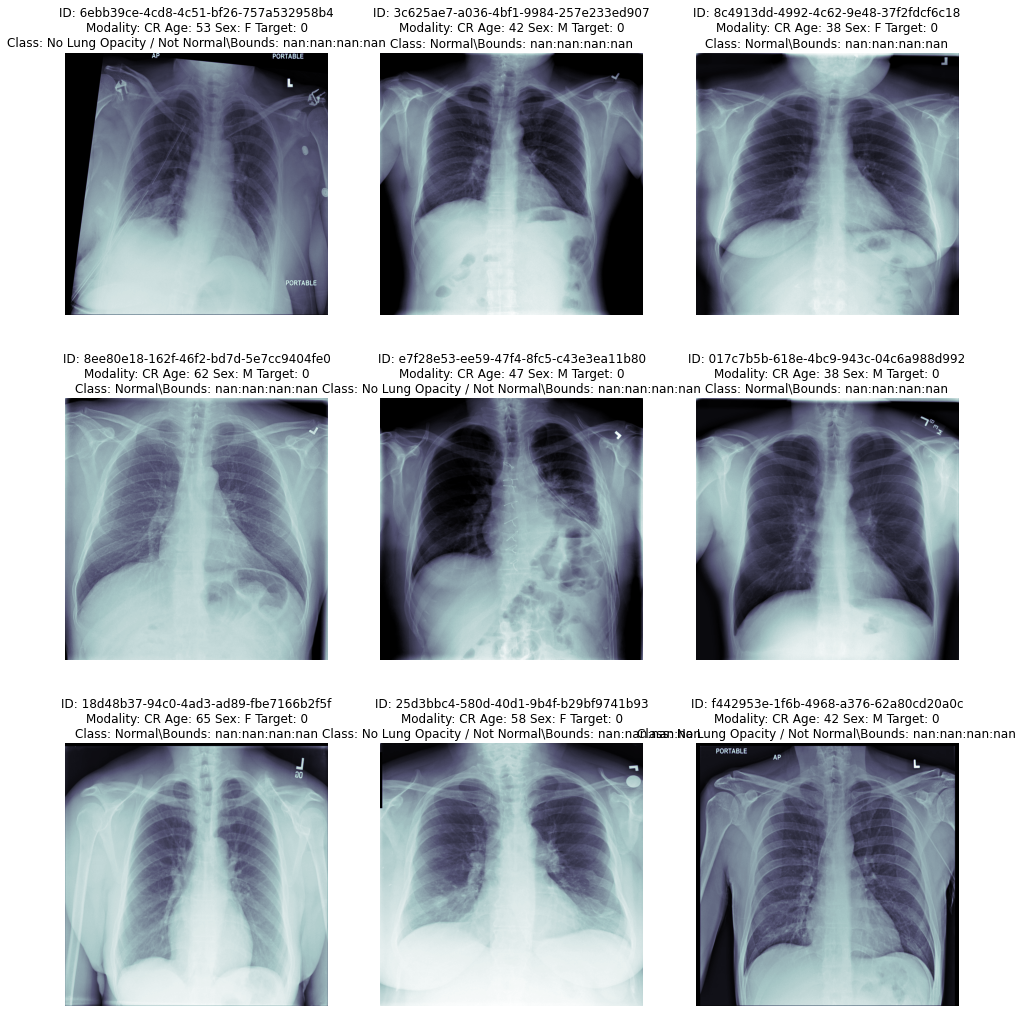

In [39]:
## checking few images which does not have pneumonia 
inspectImages(train_data[train_data['Target']==0].sample(9))



# Reading the Dicom images meta data and appending it to the training set

In [40]:
%%time
## DCIM image also being included with the meta data, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


In [41]:
%%time
## Reading the image data and append it to the training_data dataset
train_data['sex'], train_data['age'] = zip(*train_data.apply(readDCIMData, axis=1))

CPU times: user 1min 34s, sys: 5.42 s, total: 1min 39s
Wall time: 1min 49s


In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 28988
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ MB


* <b> From the above info it was clear that sex and age of the patient dont have any null values

In [43]:
# Converting age to Numeric as the current data type is a String
train_data['age'] = train_data.age.astype(int)

In [44]:
train_data.describe(include="all")

,patientId,x,y,width,height,Target,class,sex,age
count,30227,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227,30227,30227.000000
unique,26684,NaN,NaN,NaN,NaN,NaN,3,2,NaN
top,76f71a93-8105-4c79-a010-0cfa86f0061a,NaN,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal,M,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,11821,17216,NaN
mean,NaN,394.047724,366.839560,218.471376,329.269702,0.316108,NaN,NaN,46.797764
std,NaN,204.574172,148.940488,59.289475,157.750755,0.464963,NaN,NaN,16.892940
min,NaN,2.000000,2.000000,40.000000,45.000000,0.000000,NaN,NaN,1.000000
25%,NaN,207.000000,249.000000,177.000000,203.000000,0.000000,NaN,NaN,34.000000
50%,NaN,324.000000,365.000000,217.000000,298.000000,0.000000,NaN,NaN,49.000000
75%,NaN,594.000000,478.500000,259.000000,438.000000,1.000000,NaN,NaN,59.000000


# Observations of age:
   * <b>The mean age is 46 years , where as minimum age is 1 year and the maximum age is 155 which seems to be an outlier
   * <b>50% of the patiens are of around 49 age , the std deviation is 16 which suggest that age is not normally distributed

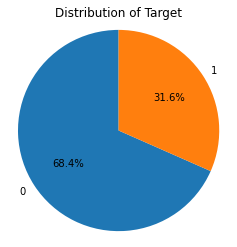

In [45]:
## Distribution of Target

label_count=train_data['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 
plt.title( "Distribution of Target")
plt.show()

# insights:
 * <b> There are 31% of patients with pneumonia and the remaining are of no pneumonia
 * <b> This indicates that there is a class imbalance issue

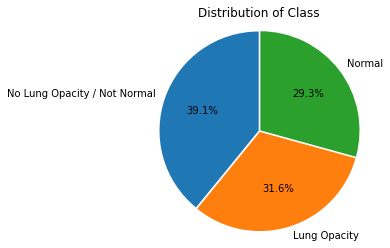

In [46]:
## Distribution of Classes

class_count=train_data['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.pie(class_count.values, explode=explode, labels=class_count.index, autopct='%1.1f%%', 
        startangle=90)
ax1.axis('equal')
plt.title('Distribution of Class')
plt.show()

# insights: 
* <b> There are 39% of patients with No Lung opacity , 
* <b> 29.3% Normal and 
* <b> the remaining are with Lung Opacity

In [47]:
# insights: 
# there are 39% of patients with No Lung opacity , 
# 29.3% Normal and 
# the remaining are with Lung Opacity

Text(0.5, 1.0, 'Class and Target  Distrubution')

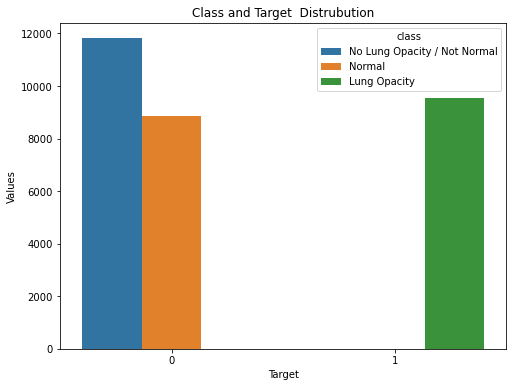

In [48]:
# distribution of target and class

fig, ax = plt.subplots(nrows = 1, figsize = (8, 6))
temp = train_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'tab10')
plt.title('Class and Target  Distrubution')

# insights:

* <b> Target 0 has only Normal or No Lung Opacity class
* <b> Target 1 has only Lung Opacity class

In [49]:
# count of gender
train_data.sex.value_counts()

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

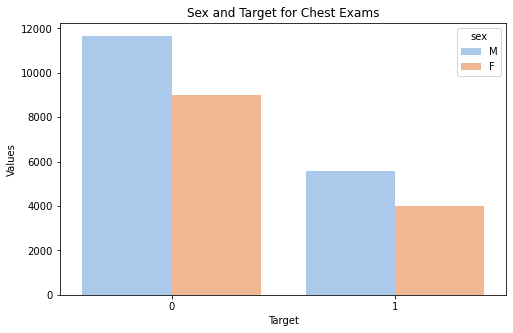

In [50]:
# Distbution of Sex among the targets
fig, ax = plt.subplots(nrows = 1, figsize = (8, 5))
temp = train_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'pastel')
plt.title('Sex and Target for Chest Exams')

# Insights:
 * <b> The number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

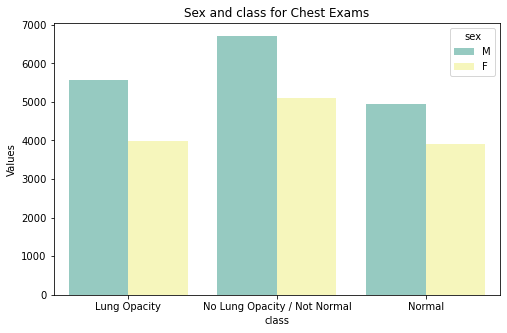

In [51]:
# # Distbution of Sex among the classes

fig, ax = plt.subplots(nrows = 1, figsize = (8, 5))
temp = train_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

# Insight:
* <b> The number of males in all classes are higher than women

<AxesSubplot:xlabel='age', ylabel='Density'>

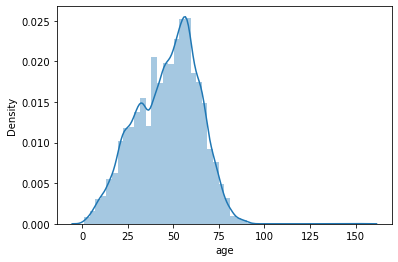

In [52]:
# plot of age distribution
# dist plot
sns.distplot(train_data.age) 

<AxesSubplot:xlabel='age', ylabel='Density'>

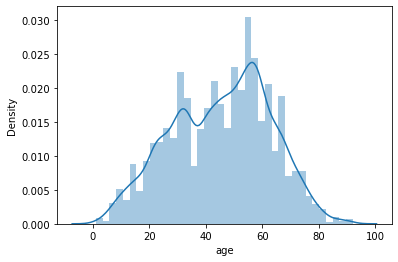

In [53]:
# Distribution of PatientAge who have pneumonia

sns.distplot(train_data.loc[train_data['Target'] == 1, 'age'])

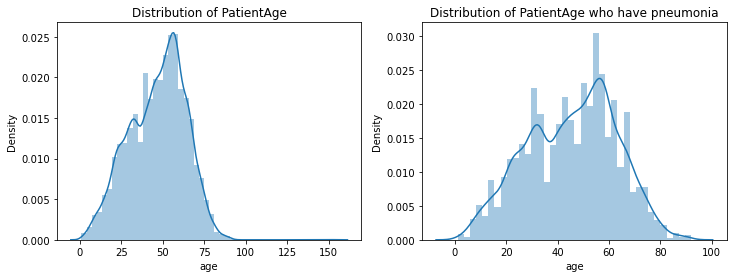

In [54]:
# Subplots

fig = plt.figure(figsize = (12, 4))

ax = fig.add_subplot(121)
g = (sns.distplot(train_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(train_data.loc[train_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

<AxesSubplot:xlabel='Target', ylabel='age'>

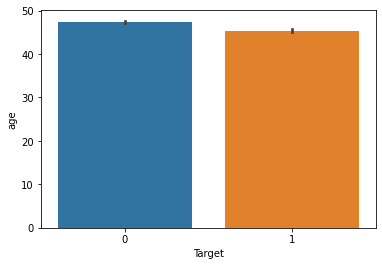

In [55]:
# distribution of Age among target

# Bar plot

sns.barplot(x='Target', y='age', data=train_data)

# Insight: 

* <b> Patients of around 45 years age are of with target class 1( having pnemonia)

<AxesSubplot:xlabel='class', ylabel='age'>

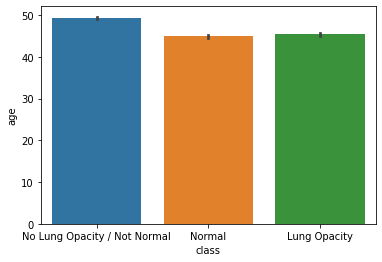

In [56]:
# Distribution of Age among class

# Bar plot
 
sns.barplot(x='class', y='age', data=train_data) 

# insight: 

* <b> Patients of around 45 years age are having lung opacity(pnemonia)

<AxesSubplot:xlabel='class', ylabel='age'>

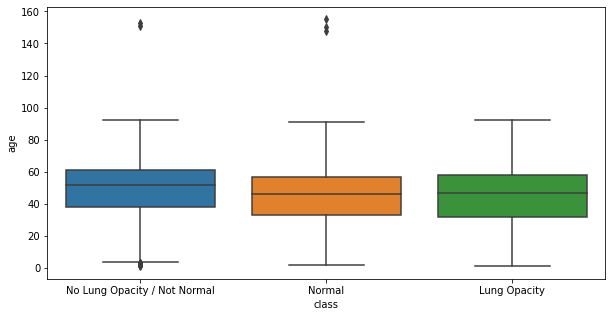

In [57]:
# Box plot

plt.figure(figsize= (10,5))
sns.boxplot (x= "class", y= "age", data= train_data)

In [58]:
# Insight of box plot:
# The class which has no pneuomia has few outliers , their age is somewhere around 150 years

<AxesSubplot:>

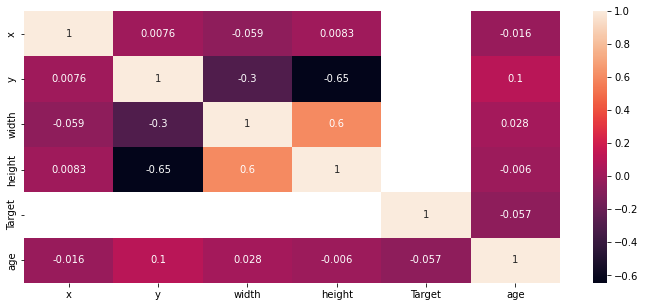

In [59]:
# corrrelation matrix
corr_mat = train_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr_mat,annot=True)

In [60]:
# Prepare data for Modelling:-

In [61]:
# We will convert the dataset to have just two classes for our ease of doing. 
# Going forward Target 0 will correspond to Normal class whereas Target 1 will corresponds with Lung Opacity.

In [62]:
train_data_df = train_data.copy()

In [63]:
#convert the dataset into two classes only:
train_data_df['class'].replace('No Lung Opacity / Not Normal', 'Normal', inplace = True)
print('The merge dataset now looks like:')
train_data_df.head()

The merge dataset now looks like:


,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [64]:
# setting all NaN values to 0 in the train_data_df datasets
# x, y, width and hight values as zero(0) means no bounding box.
train_data_df.fillna(0, inplace = True)
print('The training data now looks as: \n')
train_data_df.head()

The training data now looks as: 



,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [65]:
#convert the dataset into two classes only:
train_data_df['class'].replace('No Lung Opacity / Not Normal', 'Normal', inplace = True)
print('The merge dataset now looks like:')
train_data_df.head()

The merge dataset now looks like:


,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [66]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 28988
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 2.3+ MB


In [67]:
train_data_df['class'].value_counts()

Normal          20672
Lung Opacity     9555
Name: class, dtype: int64

In [68]:
train_sample = train_data_df.copy

In [69]:
train_data_df.head()

,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [70]:
train_data_df['class'].value_counts()

Normal          20672
Lung Opacity     9555
Name: class, dtype: int64

In [71]:

## Let's visualize a handful of positive and negative examples. 
## The function below plots five images.

def plot_five_images(images):
  """
  As the name implies, plots five images
  in a single row

  Args:
    images: list or np.array containing images

  Returns: None
  """
  # Establish an image index
  a = 1

  # Instantiate the plot
  fig = plt.figure(figsize=(15,15))

  # Plot the images
  for image in images:
    plt.subplot(1, 5, a)
    plt.imshow(image)
    plt.axis('off')
    a += 1
  plt.show()


In [72]:
#model loss
def display_loss_accuracy(x):
    '''Takes in the models history and returns a plot of the history of the log loss and the accuracy'''
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(x.history['loss'])
    plt.plot(x.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(x.history['accuracy'])
    plt.plot(x.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    return plt.show()

In [73]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model, test_x, test_y, threshold=0.5):
    """
  Applies a series of evaluation tools to generate
  a report of the model's performance.

  Args:
    model: tensorflow.python.keras.engine.training.Model
           instance trained on data

    test_x: np.array representing the test set

    test_y: np.array of test labels

    threshold: float giving the binary prediction threshold

  Returns:
    None, but displays evaluation output
    """

   # Predict from the test set
    y_probs = model.predict(x=X_test)
    y_probs = y_probs.reshape((len(y_probs),))

    # Convert to binary probabilities
    y_hat   = y_probs > threshold
    y_hat   = y_hat.reshape(len(y_hat),)

    # Plot the confusion matrix
    print('----------------------Confusion Matrix---------------------\n')

    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_hat,cmap='viridis')
#    print(cm)
    plt.show(cm)

    # Print the classification report
    print('\n\n-----------------Classification Report-----------------\n')
    print(classification_report(y_test, y_hat))

    # Display the ROC curve
    print('\n\n-----------------------ROC Curve-----------------------\n')
    fpr, tpr, thresholds = roc_curve(test_y, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [74]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes with it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [75]:
%%time
# Reading the images into numpy array
images,labels = populateImage(train_data_df)

CPU times: user 2min 10s, sys: 3.06 s, total: 2min 13s
Wall time: 2min 19s


In [76]:
images.shape , labels.shape

((30227, 128, 128, 3), (30227,))

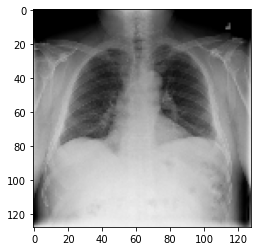

In [77]:
## Checking one of the converted image 
plt.imshow(images[1200])


In [78]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'Normal'], dtype='<U12'), 2)

In [79]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label = lb.fit_transform(labels)

In [80]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, yHNp8
i[k fgb bb,]
X_train = X_train/255

In [81]:
values, counts = np.unique(y_train, return_counts=True)
values1, counts1 = np.unique(y_test, return_counts=True)
values2, counts2 = np.unique(y_val, return_counts=True)
print("Train stratify label:",values)
print("Train stratify label counts:",counts)
print("Test stratify label:",values1)
print("Test stratify label counts:",counts1)
print("Validation stratify label:",values2)
print("Validation stratify label counts:",counts2)

Train stratify label: [0 1]
Train stratify label counts: [ 5733 12402]
Test stratify label: [0 1]
Test stratify label counts: [1911 4135]
Validation stratify label: [0 1]
Validation stratify label counts: [1911 4135]


In [82]:
percent_positive1 = y_train.sum() / len(y_train)
print('Percent of train images that are positive - %.3f' %percent_positive1)

percent_positive2 = y_test.sum() / len(y_test)
print('Percent of test images that are positive - %.3f' %percent_positive2)

percent_positive3 = y_val.sum() / len(y_val)
print('Percent of test images that are positive - %.3f' %percent_positive3)

Percent of train images that are positive - 0.684
Percent of test images that are positive - 0.684
Percent of test images that are positive - 0.684


In [83]:
## Function to create a dataframe for results
def createResult(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'Accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

# Model-1 with 2 classes

In [84]:
%%time
# Basic model
batch_size = 100
epochs = 30

random_state=22

model1= Sequential()
model1.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
model1.add(MaxPooling2D(2,2))
    
model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.5))
    
model1.add(Conv2D(128,(3,3),activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.5))
    
model1.add(Conv2D(256,(3,3),activation='relu'))
model1.add(MaxPooling2D(2,2))
    
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(256,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

# compiling the model

model1.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# Fitting the model

history1 = model1.fit(X_train, 
                  y_train, 
                  epochs = epochs, 
                  validation_data =(X_val,y_val),
                  batch_size = batch_size,verbose = 1)

Metal device set to: Apple M1 Pro


2022-08-23 04:27:41.310944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-23 04:27:41.311831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2022-08-23 04:27:59.622556: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-23 04:28:00.097956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.6969

2022-08-23 04:28:21.042613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 23s 122ms/step - loss: 0.5878 - accuracy: 0.6969 - val_loss: 0.5208 - val_accuracy: 0.7101
Epoch 2/30
182/182 [==============================] - 18s 99ms/step - loss: 0.4958 - accuracy: 0.7593 - val_loss: 0.5027 - val_accuracy: 0.7653
Epoch 3/30
182/182 [==============================] - 18s 98ms/step - loss: 0.4833 - accuracy: 0.7707 - val_loss: 0.5014 - val_accuracy: 0.7569
Epoch 4/30
182/182 [==============================] - 18s 98ms/step - loss: 0.4769 - accuracy: 0.7747 - val_loss: 0.4944 - val_accuracy: 0.7741
Epoch 5/30
182/182 [==============================] - 18s 99ms/step - loss: 0.4717 - accuracy: 0.7774 - val_loss: 0.4725 - val_accuracy: 0.7752
Epoch 6/30
182/182 [==============================] - 18s 99ms/step - loss: 0.4671 - accuracy: 0.7818 - val_loss: 0.4914 - val_accuracy: 0.7726
Epoch 7/30
182/182 [==============================] - 18s 99ms/step - loss: 0.4641 - accuracy: 0.7825 - val_loss: 0.4706 - val_accuracy: 0.7789
Ep

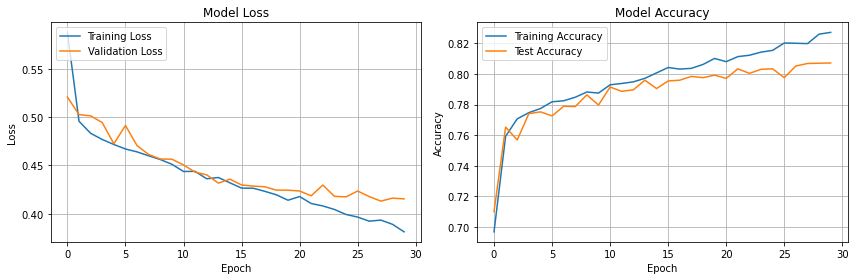

In [85]:
# Visualisation of training and validation accuracy Vs their loss
train1_acc = history1.history['accuracy']
display_loss_accuracy(history1)


In [86]:
# Insights of basic model with 2 classes:

# there has been dip in the traning loss but validation loss has no much significant dip in loss
# Validation accuracy went up to 77.28% approx
# while training accuracy was 77.87% and test accuracy was 79.17%

In [87]:
# Evaluating the accuracy
model1_test_loss, model1_test_acc = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', model1_test_loss)
print('Test accuracy:',model1_test_acc)

189/189 [==============================] - 5s 24ms/step - loss: 0.4141 - accuracy: 0.8098
Test loss: 0.4140545129776001
Test accuracy: 0.809791624546051


In [88]:
resultDF1 = createResult("CNN model with 2 classes",train1_acc[-1],model1_test_acc)
resultDF1

,Method,Accuracy,Test Score
0,CNN model with 2 classes,0.82713,0.809792


  1/189 [..............................] - ETA: 1:35

2022-08-23 04:37:36.529487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 4s 20ms/step
----------------------Confusion Matrix---------------------



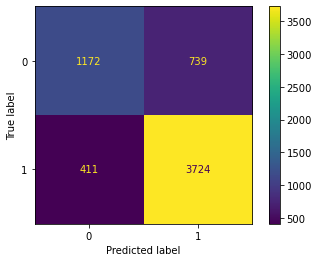



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.74      0.61      0.67      1911
           1       0.83      0.90      0.87      4135

    accuracy                           0.81      6046
   macro avg       0.79      0.76      0.77      6046
weighted avg       0.80      0.81      0.80      6046



-----------------------ROC Curve-----------------------



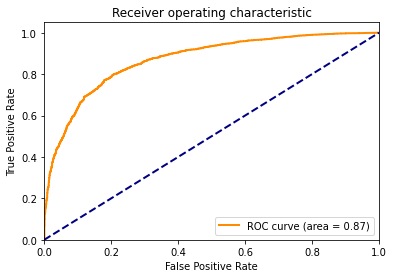

In [89]:
evaluate_model(model1, X_test, y_test)

In [90]:
# Predict from the test set
threshold = 0.5
# Predict from the test set
y_prob1 = model1.predict(x=X_test)
y_prob1 = y_prob1.reshape((len(y_prob1),))

    # Convert to binary probabilities
y_hat1   = y_prob1 > threshold
y_hat1   = y_hat1.reshape(len(y_hat1),)

    
reportData = classification_report(y_test, y_hat1,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF1[data+"_"+subData] = reportData[data][subData]
resultDF1

189/189 [==============================] - 4s 20ms/step


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classes,0.82713,0.809792,0.834416,0.900605,0.866248,4135


# Model-2 with 3 classes

In [91]:
 train_data.head()

,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [92]:
# making a copy of the train data
sample_traindata = train_data.copy()

In [93]:
## Checking the training data set with class distbution 
sample_traindata["class"].value_counts()


No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [94]:
sample_traindata.head()

,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [95]:
sample_traindata.fillna(0, inplace = True)
print('The training data now looks as: \n')
sample_traindata.head()

The training data now looks as: 



,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,F,51
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,F,19
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,F,25
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,F,25
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,M,40


In [96]:
sampleimages = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
samplelabels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [97]:
%%time
sampleimages,samplelabels = populateImage(sample_traindata)

CPU times: user 2min 15s, sys: 10.7 s, total: 2min 26s
Wall time: 2min 38s


In [98]:
sampleimages.shape , samplelabels.shape

((30227, 128, 128, 3), (30227,))

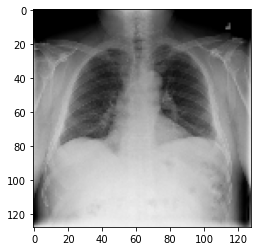

In [99]:
## Checking one of the converted image 
plt.imshow(sampleimages[1200])

In [100]:
## check the unique labels
np.unique(samplelabels),len(np.unique(samplelabels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [101]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
ysample = lb.fit_transform(samplelabels)

In [102]:
# Train test split for 3 class dataset

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(sampleimages, ysample, test_size=0.2, shuffle = True,random_state=22, stratify=ysample)
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train_c, y_train_c, test_size=0.25, shuffle = True,random_state=22 ,stratify=y_train_c)

X_train_c = X_train_c/255
X_test_c = X_test_c/255
X_val_c = X_val_c/255

In [103]:
%%time
# Basic CNN model: used 32 filters with kernel size (3, 3) followed by 64, 128 and 256 filters with same kernel size
# with maximum pooling and drop outs
# finally used softmax activation layer
random_state=22

model2= Sequential()
model2.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
    
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.5))
    
model2.add(Conv2D(128,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.5))
    
model2.add(Conv2D(256,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
    
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(3,activation='softmax'))

# compiling the model

model2.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

# Fitting the model

history2 = model2.fit(X_train_c, 
                  y_train_c, 
                  epochs = epochs, 
                  validation_data =(X_val_c,y_val_c),
                  batch_size = batch_size,verbose = 1)

Epoch 1/30


2022-08-23 04:41:24.387435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 1.1050 - accuracy: 0.3845

2022-08-23 04:41:45.586292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 24s 127ms/step - loss: 1.1050 - accuracy: 0.3845 - val_loss: 1.0887 - val_accuracy: 0.3910
Epoch 2/30
182/182 [==============================] - 19s 103ms/step - loss: 0.9311 - accuracy: 0.5310 - val_loss: 0.9147 - val_accuracy: 0.5772
Epoch 3/30
182/182 [==============================] - 19s 103ms/step - loss: 0.8702 - accuracy: 0.5794 - val_loss: 0.8922 - val_accuracy: 0.5648
Epoch 4/30
182/182 [==============================] - 19s 103ms/step - loss: 0.8468 - accuracy: 0.5865 - val_loss: 0.8895 - val_accuracy: 0.5655
Epoch 5/30
182/182 [==============================] - 19s 103ms/step - loss: 0.8233 - accuracy: 0.6054 - val_loss: 0.8442 - val_accuracy: 0.6019
Epoch 6/30
182/182 [==============================] - 19s 104ms/step - loss: 0.8133 - accuracy: 0.6072 - val_loss: 0.8331 - val_accuracy: 0.6070
Epoch 7/30
182/182 [==============================] - 19s 103ms/step - loss: 0.8052 - accuracy: 0.6183 - val_loss: 0.8520 - val_accuracy: 0.5

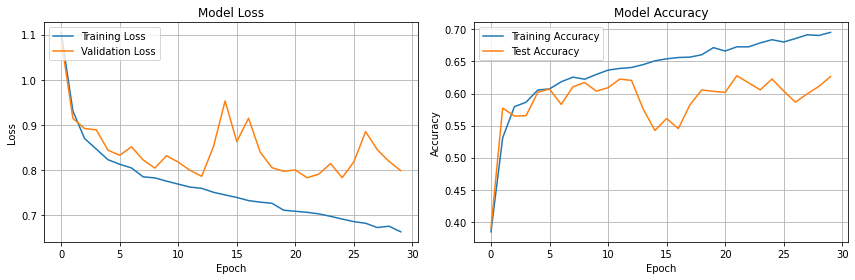

In [104]:
## Plotting the accuracy vs loss graph
train2_acc = history2.history['accuracy']
display_loss_accuracy(history2)

In [106]:
## evaluating the acuracy
model2_test_loss, model2_test_acc = model2.evaluate(X_test_c, y_test_c)
print('Test loss:', model2_test_loss)
print('Test accuracy:', model2_test_acc)

189/189 [==============================] - 5s 26ms/step - loss: 0.8131 - accuracy: 0.6232
Test loss: 0.8131052851676941
Test accuracy: 0.6232219934463501


In [107]:
resultDF2 = createResult("CNN model with 3 classes",train2_acc[-1],model2_test_acc)
resultDF2

,Method,Accuracy,Test Score
0,CNN model with 3 classes,0.69523,0.623222


  1/189 [..............................] - ETA: 55s

2022-08-23 04:51:31.879824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 4s 20ms/step


-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.70      0.53      0.60      1911
           1       0.55      0.58      0.57      2365
           2       0.66      0.78      0.71      1770

    accuracy                           0.62      6046
   macro avg       0.64      0.63      0.63      6046
weighted avg       0.63      0.62      0.62      6046



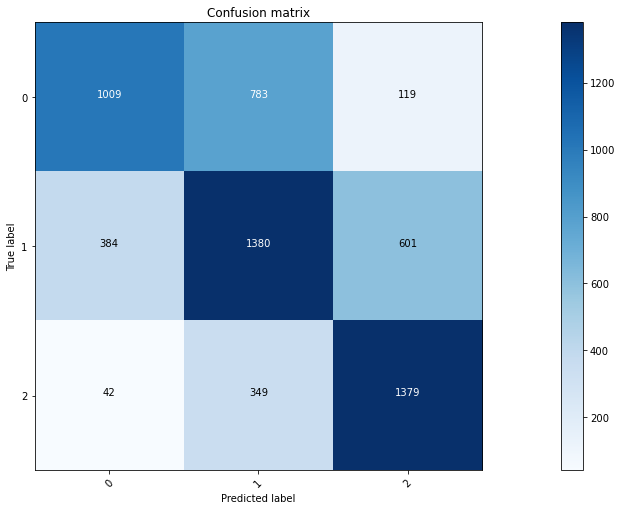

In [108]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import itertools


#Class 0 ,1 and 2:
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal
#Class 2 is Normal

plt.subplots(figsize=(22,7)) #setting the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predicting the values from the validation dataset
y_pred_3c = model2.predict(X_test_c)
# Converting predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_3c,axis = 1) 
# Convert validation observations to one hot vectors
y_true_c = np.argmax(y_test_c,axis = 1) 
# computing the confusion matrix
confusion_mtx = confusion_matrix(y_true_c, y_pred_classes) 
# plotting the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))


# Print the classification report
print('\n\n-----------------Classification Report-----------------\n')
print(classification_report(y_true_c, y_pred_classes))


In [109]:
# the model has predicted mostly wrong in this case to the Target 0. Type 2 error

In [110]:
# classification report

from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report


reportData = classification_report(y_true_c, y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF2[data+"_"+subData] = reportData[data][subData]

resultDF2

,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 3 classes,0.69523,0.623222,0.549363,0.58351,0.565922,2365


# Model-1 with Data Augumentation(2 classes)

**Model-1 with 2 classes performing well with good accuracy score when compared with Model-2 with 3 classes. So we chosen Model-1 to train the data augumentation images.**

# Data Augmentation

**The training generator lets you flow augmented data into the model.**

**Data augmentation involves perturbing the training data to increase the size of the data and reduce overfitting.**

**Normalise the pixel values by dividing by 255.**

** We also used horizontal flips, rotations of up to 40 degrees, and other distortions.**

**Importantly, the validation and test sets only rescale the pixel intensity.**

**We are careful not to augment validation and test sets.**

In [111]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
#    rescale=1/255,
    horizontal_flip=True,
    rotation_range=40,
    shear_range=0.25,
    zoom_range=0.2)

#train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
#    rotation_range = 40,  # randomly rotate images in the range (degrees, 0 to 180)
#    zoom_range = 0.2, # Randomly zoom image 
#    shear_range=0.25
#    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#    horizontal_flip = True,  # randomly flip images
#    vertical_flip=False
#)

valid_gen  = tf.keras.preprocessing.image.ImageDataGenerator()
  
                                    
train_generator = train_gen.flow(
    X_train,
    y_train,
    batch_size=batch_size)
  
valid_generator = valid_gen.flow(
    X_val,
    y_val,
    batch_size=batch_size)




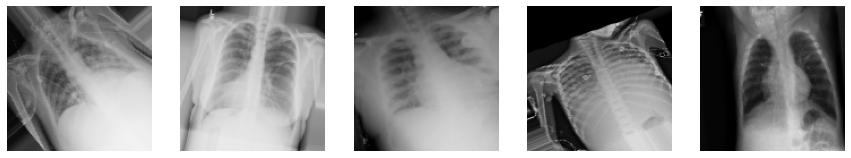

In [112]:
# Plotting the augmented images gives a sense of how the images are manipulated.
X_plot, y_plot = next(train_generator)
plot_five_images(X_plot[:5])

In [113]:
# We are going to train the model-1 with data augumentation images.

In [114]:
%%time
random_state=22

# Basic model
model3= Sequential()
model3.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
model3.add(MaxPooling2D(2,2))
    
model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(0.2))
    
model3.add(Conv2D(128,(3,3),activation='relu'))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(0.2))
    
model3.add(Conv2D(256,(3,3),activation='relu'))
model3.add(MaxPooling2D(2,2))
    
model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(256,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

# compiling the model

model3.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# Fitting the model

history3 = model3.fit(x=train_generator,
                  epochs = epochs, 
                  validation_data=valid_generator,
                  batch_size = batch_size,
                  verbose = 1)

Epoch 1/30


2022-08-23 04:52:11.856291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.7017

2022-08-23 04:52:46.387798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 39s 207ms/step - loss: 0.5841 - accuracy: 0.7017 - val_loss: 0.4886 - val_accuracy: 0.7625
Epoch 2/30
182/182 [==============================] - 35s 191ms/step - loss: 0.4996 - accuracy: 0.7549 - val_loss: 0.4837 - val_accuracy: 0.7701
Epoch 3/30
182/182 [==============================] - 35s 192ms/step - loss: 0.4896 - accuracy: 0.7662 - val_loss: 0.4995 - val_accuracy: 0.7602
Epoch 4/30
182/182 [==============================] - 35s 189ms/step - loss: 0.4797 - accuracy: 0.7745 - val_loss: 0.4829 - val_accuracy: 0.7698
Epoch 5/30
182/182 [==============================] - 35s 190ms/step - loss: 0.4822 - accuracy: 0.7696 - val_loss: 0.4975 - val_accuracy: 0.7706
Epoch 6/30
182/182 [==============================] - 34s 187ms/step - loss: 0.4763 - accuracy: 0.7746 - val_loss: 0.4698 - val_accuracy: 0.7736
Epoch 7/30
182/182 [==============================] - 35s 190ms/step - loss: 0.4763 - accuracy: 0.7759 - val_loss: 0.4712 - val_accuracy: 0.7

In [115]:
# Evaluating the acuracy , we have only got accuracy of 74% for both train and test.
model3_test_loss, model3_test_acc = model3.evaluate(X_test, y_test, verbose=1)
print('Test Loss of the model is -:', model3_test_loss)
print('Test Accuracy of the model is:', model3_test_acc)

189/189 [==============================] - 4s 23ms/step - loss: 0.4153 - accuracy: 0.8058
Test Loss of the model is -: 0.41530779004096985
Test Accuracy of the model is: 0.8058220148086548


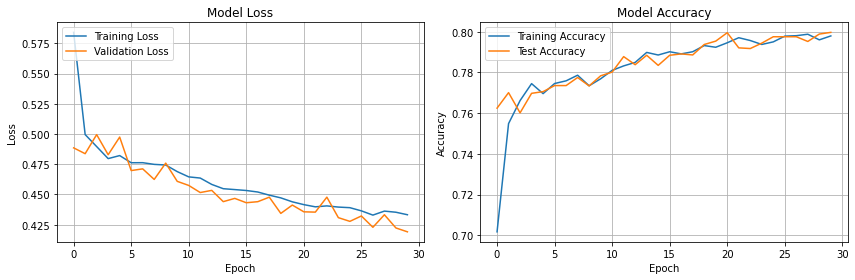

In [116]:
## Plottting the accuracy vs loss graph
train3_acc = history3.history['accuracy']
display_loss_accuracy(history3)

In [117]:
# printing the dataframe
resultDF3 = createResult("CNN model-1 with Augumentation",train3_acc[-1],model3_test_acc)
resultDF3

,Method,Accuracy,Test Score
0,CNN model-1 with Augumentation,0.79796,0.805822


In [118]:
# Predict from the test set
threshold = 0.5
# Predict from the test set
y_prob3 = model3.predict(x=X_test)
y_prob3 = y_prob3.reshape((len(y_prob3),))

    # Convert to binary probabilities
y_hat3   = y_prob3 > threshold
y_hat3   = y_hat3.reshape(len(y_hat3),)

    
reportData = classification_report(y_test, y_hat3,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF3[data+"_"+subData] = reportData[data][subData]

resultDF3

  9/189 [>.............................] - ETA: 3s

2022-08-23 05:10:22.558407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 4s 19ms/step


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model-1 with Augumentation,0.79796,0.805822,0.829659,0.901088,0.8639,4135


189/189 [==============================] - 4s 19ms/step
----------------------Confusion Matrix---------------------



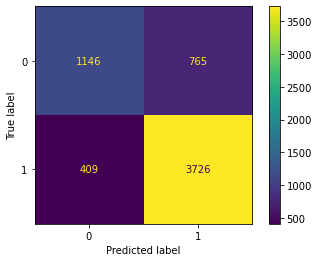



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.74      0.60      0.66      1911
           1       0.83      0.90      0.86      4135

    accuracy                           0.81      6046
   macro avg       0.78      0.75      0.76      6046
weighted avg       0.80      0.81      0.80      6046



-----------------------ROC Curve-----------------------



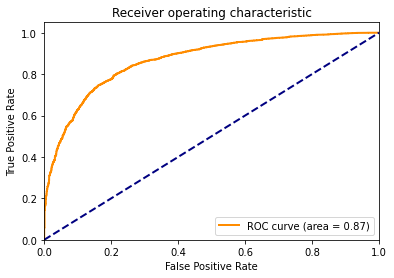

In [119]:
evaluate_model(model3, X_test, y_test)

In [120]:
df =pd.concat([resultDF1,resultDF2,resultDF3],ignore_index=True)
df

,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classes,0.82713,0.809792,0.834416,0.900605,0.866248,4135
1,CNN model with 3 classes,0.69523,0.623222,0.549363,0.583510,0.565922,2365
2,CNN model-1 with Augumentation,0.79796,0.805822,0.829659,0.901088,0.863900,4135


In [121]:
## Creating a Copy feature use.
X_train1 = X_train.copy()
X_test1 = X_test.copy()

In [122]:
!pwd

/Users/seenu/tensorflow/rsna-pneumonia-detection-challenge


In [ ]:
# Insights:

# The best model is Model-1 (with 2 classes) when compared with Model-2 (with 3 classes).

# So, we chosen Model-1 for further analysis.

# The Model-1 with data augmentation performs fairly well with sample images.

# It's tremendously satisfying to see a simple model make substantial headway on learning a difficult task.

# Next steps would include an investigation of alternative model architectures, more robust hyperparameter optimization, 
# and investigating transfer learning using models trained on similar images.

# Transfer Learning

# Modeling - Using VGG16 with trainable = False

      VGG-19 is a transfer learning alorithm which means its an algorithm with 16 convolutional layers that focuses on storing knowledge that can be applied to different but relaed problems.
  
     VGGNet is a well-documented and globally used architecture for convolutional neural network.
 
    Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable



In [123]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False ## Not trainable weights


In [124]:
## Adding two hidden later and one softmax layer as an output layer

from tensorflow.keras import layers, models

max_layer = MaxPooling2D(pool_size=(2,2), strides=2)
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
drop_layer_2 = layers.Dropout(0.5)
pred_layer = layers.Dense(1, activation='sigmoid')

CNN_VGG16_model = models.Sequential([
    base_model,
    max_layer,
    flatten_layer,
    dense_layer_1,
    drop_layer_2,
    pred_layer
])

In [125]:
CNN_VGG16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 2, 512)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                      

In [126]:
from tensorflow.keras.callbacks import EarlyStopping

models_loss = 'binary_crossentropy'

models_opt = 'adam'

checkpoint = ModelCheckpoint('Best_CNN_VGG16_model' + '.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

es = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=10,
                                verbose=1,
                                factor=0.8,
                                min_lr=0.0001,
                                mode="auto",
                                min_delta=0.0001,
                                cooldown=5)

callbacks = [checkpoint, es, lr_reduction]

CNN_VGG16_model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

In [127]:
%%time
random_state=22

#Training the model

history4 = CNN_VGG16_model.fit(X_train, 
                              y_train, 
                              epochs=epochs, 
                              validation_data=valid_generator,
                              batch_size = batch_size,
                              callbacks=callbacks)

Epoch 1/30


2022-08-23 05:12:02.043721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.7580

2022-08-23 05:12:46.419855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.44918, saving model to Best_CNN_VGG16_model.h5
182/182 [==============================] - 60s 322ms/step - loss: 0.5129 - accuracy: 0.7580 - val_loss: 0.4492 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 2/30
182/182 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.7827
Epoch 2: val_loss did not improve from 0.44918
182/182 [==============================] - 58s 321ms/step - loss: 0.4549 - accuracy: 0.7827 - val_loss: 0.4612 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 3/30
182/182 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.7931
Epoch 3: val_loss improved from 0.44918 to 0.43875, saving model to Best_CNN_VGG16_model.h5
182/182 [==============================] - 58s 321ms/step - loss: 0.4419 - accuracy: 0.7931 - val_loss: 0.4387 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 4/30
182/182 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7955
Epoch 4: val_loss improved from 0.43875 to 

In [128]:
# Evaluating the acuracy , we have only got accuracy of 74% for both train and test.
model4_test_loss, model4_test_acc = CNN_VGG16_model.evaluate(X_test, y_test, verbose=1)
print('Test Loss of the model is -:', model4_test_loss)
print('Test Accuracy of the model is:', model4_test_acc)

189/189 [==============================] - 15s 79ms/step - loss: 0.4209 - accuracy: 0.8015
Test Loss of the model is -: 0.42093902826309204
Test Accuracy of the model is: 0.8015216588973999


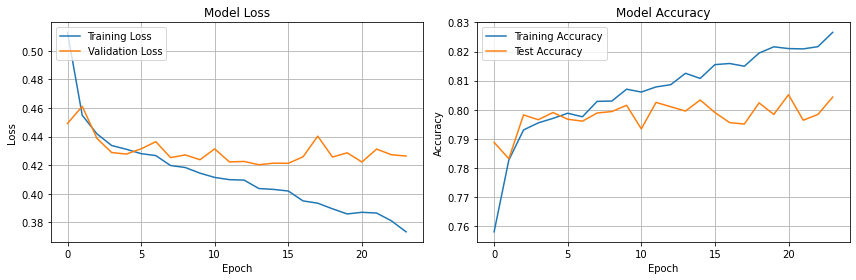

In [129]:
# Plottting the accuracy vs loss graph
train4_acc = history4.history['accuracy']

display_loss_accuracy(history4)

In [130]:
# printing the dataframe
resultDF4 = createResult("CNN_VGG16_model with trainable -False",train4_acc[-1],model4_test_acc)
resultDF4

,Method,Accuracy,Test Score
0,CNN_VGG16_model with trainable -False,0.826578,0.801522


In [131]:
# Predict from the test set
threshold = 0.5
# Predict from the test set
y_prob4 = CNN_VGG16_model.predict(x=X_test)
y_prob4 = y_prob4.reshape((len(y_prob4),))

    # Convert to binary probabilities
y_hat4   = y_prob4 > threshold
y_hat4   = y_hat4.reshape(len(y_hat4),)

    
reportData = classification_report(y_test, y_hat4,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF4[data+"_"+subData] = reportData[data][subData]

resultDF4

2022-08-23 05:37:59.615791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 15s 76ms/step


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN_VGG16_model with trainable -False,0.826578,0.801522,0.830146,0.892382,0.86014,4135


189/189 [==============================] - 17s 90ms/step
----------------------Confusion Matrix---------------------



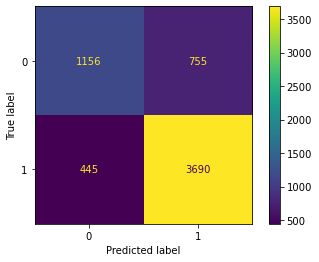



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.72      0.60      0.66      1911
           1       0.83      0.89      0.86      4135

    accuracy                           0.80      6046
   macro avg       0.78      0.75      0.76      6046
weighted avg       0.80      0.80      0.80      6046



-----------------------ROC Curve-----------------------



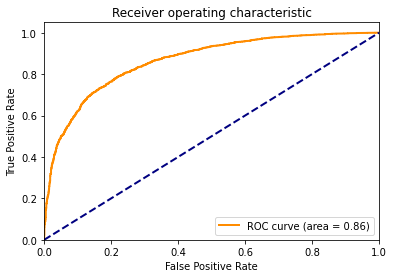

In [132]:
evaluate_model(CNN_VGG16_model, X_test, y_test)

In [133]:

df =pd.concat([resultDF1,resultDF2,resultDF3,resultDF4],ignore_index=True)
df

,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classes,0.827130,0.809792,0.834416,0.900605,0.866248,4135
1,CNN model with 3 classes,0.695230,0.623222,0.549363,0.583510,0.565922,2365
2,CNN model-1 with Augumentation,0.797960,0.805822,0.829659,0.901088,0.863900,4135
3,CNN_VGG16_model with trainable -False,0.826578,0.801522,0.830146,0.892382,0.860140,4135


# Modeling - Using VGG16 with trainable = True

In [134]:
base_model1 = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model1.trainable = True ## Not trainable weights

In [135]:
from tensorflow.keras import layers, models

max_layer = MaxPooling2D(pool_size=(2,2), strides=2)
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
drop_layer_2 = layers.Dropout(0.5)
pred_layer = layers.Dense(1, activation='sigmoid')

CNN_VGG16_model1 = models.Sequential([
    base_model1,
    max_layer,
    flatten_layer,
    dense_layer_1,
    drop_layer_2,
    pred_layer
])

In [136]:
CNN_VGG16_model1.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

In [137]:
%%time
random_state=22

#Training the model

history5 = CNN_VGG16_model1.fit(X_train, 
                              y_train, 
                              epochs=epochs, 
                              validation_data=valid_generator,
                              batch_size = batch_size,
                              callbacks=callbacks)


Epoch 1/30


2022-08-23 05:39:28.333568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.6821

2022-08-23 05:42:14.622415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss did not improve from 0.42029
182/182 [==============================] - 184s 1s/step - loss: 0.6466 - accuracy: 0.6821 - val_loss: 0.6476 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 2/30
182/182 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7553
Epoch 2: val_loss did not improve from 0.42029
182/182 [==============================] - 182s 1s/step - loss: 0.5045 - accuracy: 0.7553 - val_loss: 0.4607 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/30
182/182 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.7805
Epoch 3: val_loss did not improve from 0.42029
182/182 [==============================] - 182s 1s/step - loss: 0.4705 - accuracy: 0.7805 - val_loss: 0.5232 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 4/30
182/182 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.7763
Epoch 4: val_loss did not improve from 0.42029
182/182 [==============================] - 182s 1s/step - loss: 0.4738 - accuracy: 0.776

In [138]:
#CNN_VGG16_model1.save('best_VGG16_model_trainable.h5')

In [139]:
#best_model = tf.keras.models.load_model('best_VGG16_model_trainable.h5')

In [140]:
model5_test_loss, model5_test_acc = CNN_VGG16_model1.evaluate(X_test, y_test, verbose=1)
print('Test Loss of the model is -:', model5_test_loss)
print('Test Accuracy of the model is:', model5_test_acc)

189/189 [==============================] - 18s 92ms/step - loss: 0.4042 - accuracy: 0.8186
Test Loss of the model is -: 0.4041914939880371
Test Accuracy of the model is: 0.8185577392578125


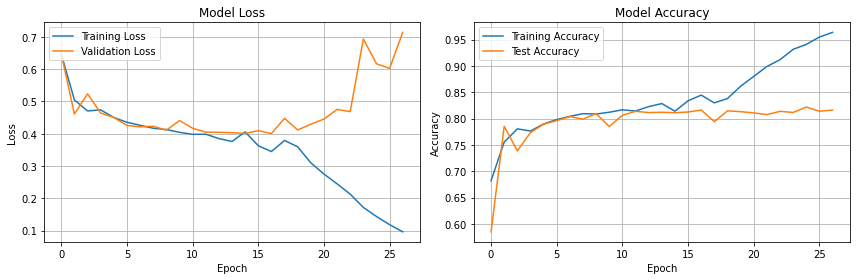

In [141]:
#Plottting the accuracy vs loss graph
train5_acc = history5.history['accuracy']
#Plottting the accuracy vs loss graph
display_loss_accuracy(history5)

In [142]:
# printing the dataframe
resultDF5 = createResult("CNN_VGG16_model with trainable -True",train5_acc[-1],model5_test_acc)
resultDF5



,Method,Accuracy,Test Score
0,CNN_VGG16_model with trainable -True,0.963606,0.818558


In [143]:
# Predict from the test set
threshold = 0.5
# Predict from the test set
y_prob5 = CNN_VGG16_model1.predict(x=X_test)
y_prob5 = y_prob5.reshape((len(y_prob5),))

    # Convert to binary probabilities
y_hat5   = y_prob5 > threshold
y_hat5   = y_hat5.reshape(len(y_hat5),)

    
reportData = classification_report(y_test, y_hat5,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF5[data+"_"+subData] = reportData[data][subData]

resultDF5

  1/189 [..............................] - ETA: 41s

2022-08-23 07:02:25.166122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 17s 89ms/step


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN_VGG16_model with trainable -True,0.963606,0.818558,0.871394,0.861911,0.866626,4135


189/189 [==============================] - 17s 89ms/step
----------------------Confusion Matrix---------------------



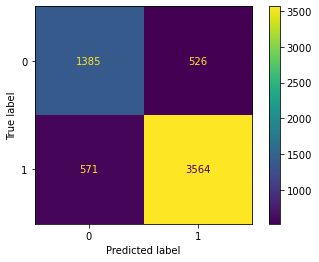



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1911
           1       0.87      0.86      0.87      4135

    accuracy                           0.82      6046
   macro avg       0.79      0.79      0.79      6046
weighted avg       0.82      0.82      0.82      6046



-----------------------ROC Curve-----------------------



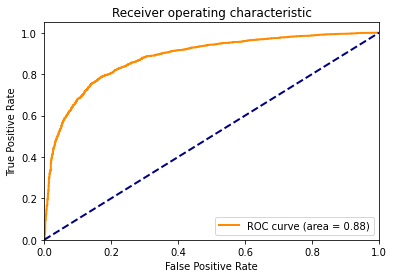

In [144]:
evaluate_model(CNN_VGG16_model1, X_test, y_test)

In [145]:

df =pd.concat([resultDF1,resultDF2,resultDF3,resultDF4,resultDF5],ignore_index=True)
df

,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classes,0.827130,0.809792,0.834416,0.900605,0.866248,4135
1,CNN model with 3 classes,0.695230,0.623222,0.549363,0.583510,0.565922,2365
2,CNN model-1 with Augumentation,0.797960,0.805822,0.829659,0.901088,0.863900,4135
3,CNN_VGG16_model with trainable -False,0.826578,0.801522,0.830146,0.892382,0.860140,4135
4,CNN_VGG16_model with trainable -True,0.963606,0.818558,0.871394,0.861911,0.866626,4135


# InceptionNet

Also known as GoogleNet, this architecture presents sub-networks called inception modules, which allows fast training computing, complex patterns detection, and optimal use of parameters

In [146]:
from keras.applications import InceptionV3

inception_base_model = InceptionV3(input_shape=(128,128,3),include_top=False,weights='imagenet')

In [147]:
inception_model = Sequential([
        inception_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])


In [150]:
%%time
random_state=22
#opt = tf.keras.optimizers.Adam(lr=0.001)
    
inception_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                        loss = 'binary_crossentropy',metrics=['accuracy'])

history6 = inception_model.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = valid_generator,
                    verbose = 1)

Epoch 1/30


2022-08-23 07:04:23.913827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.6067

2022-08-23 07:05:53.957968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 103s 482ms/step - loss: 0.7758 - accuracy: 0.6067 - val_loss: 0.5735 - val_accuracy: 0.7177
Epoch 2/30
182/182 [==============================] - 79s 434ms/step - loss: 0.5869 - accuracy: 0.7232 - val_loss: 0.6000 - val_accuracy: 0.7627
Epoch 3/30
182/182 [==============================] - 80s 435ms/step - loss: 0.5081 - accuracy: 0.7742 - val_loss: 0.6639 - val_accuracy: 0.7840
Epoch 4/30
182/182 [==============================] - 79s 430ms/step - loss: 0.4693 - accuracy: 0.7917 - val_loss: 0.5966 - val_accuracy: 0.7734
Epoch 5/30
182/182 [==============================] - 81s 443ms/step - loss: 0.4436 - accuracy: 0.7997 - val_loss: 0.4278 - val_accuracy: 0.8210
Epoch 6/30
182/182 [==============================] - 80s 437ms/step - loss: 0.4303 - accuracy: 0.8039 - val_loss: 0.5076 - val_accuracy: 0.7989
Epoch 7/30
182/182 [==============================] - 79s 432ms/step - loss: 0.4103 - accuracy: 0.8156 - val_loss: 0.4066 - val_accuracy: 0.

In [151]:
model6_test_loss, model6_test_acc = inception_model.evaluate(X_test, y_test, verbose=1)
print('Test Loss of the model is -:', model6_test_loss)
print('Test Accuracy of the model is:', model6_test_acc)

189/189 [==============================] - 9s 43ms/step - loss: 0.4693 - accuracy: 0.8224
Test Loss of the model is -: 0.46931472420692444
Test Accuracy of the model is: 0.8223618865013123


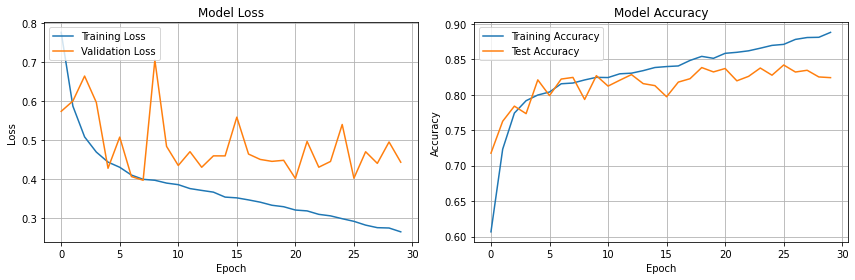

In [152]:
train6_acc = history6.history['accuracy']
#Plottting the accuracy vs loss graph
display_loss_accuracy(history6)

In [153]:
# printing the dataframe
resultDF6 = createResult("inception_base_model",train6_acc[-1],model6_test_acc)
resultDF6

,Method,Accuracy,Test Score
0,inception_base_model,0.888062,0.822362


189/189 [==============================] - 7s 35ms/step
----------------------Confusion Matrix---------------------



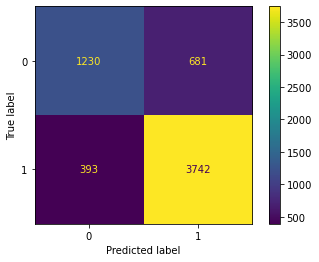



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.76      0.64      0.70      1911
           1       0.85      0.90      0.87      4135

    accuracy                           0.82      6046
   macro avg       0.80      0.77      0.79      6046
weighted avg       0.82      0.82      0.82      6046



-----------------------ROC Curve-----------------------



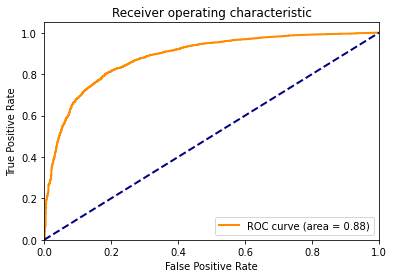

In [155]:
evaluate_model(inception_model, X_test, y_test)

In [156]:
# Predict from the test set
threshold = 0.5
# Predict from the test set
y_prob6 = inception_model.predict(x=X_test)
y_prob6 = y_prob6.reshape((len(y_prob6),))

    # Convert to binary probabilities
y_hat6   = y_prob6 > threshold
y_hat6   = y_hat6.reshape(len(y_hat6),)

    
reportData = classification_report(y_test, y_hat6,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF6[data+"_"+subData] = reportData[data][subData]

resultDF6

189/189 [==============================] - 7s 35ms/step


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,inception_base_model,0.888062,0.822362,0.846032,0.904958,0.874503,4135


In [157]:
df =pd.concat([resultDF1,resultDF2,resultDF3,resultDF4,
              resultDF5,resultDF6],ignore_index=True)
df

,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classes,0.827130,0.809792,0.834416,0.900605,0.866248,4135
1,CNN model with 3 classes,0.695230,0.623222,0.549363,0.583510,0.565922,2365
2,CNN model-1 with Augumentation,0.797960,0.805822,0.829659,0.901088,0.863900,4135
3,CNN_VGG16_model with trainable -False,0.826578,0.801522,0.830146,0.892382,0.860140,4135
4,CNN_VGG16_model with trainable -True,0.963606,0.818558,0.871394,0.861911,0.866626,4135
5,inception_base_model,0.888062,0.822362,0.846032,0.904958,0.874503,4135


# DenseNet

In [161]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(128, 128, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 4, 4, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 4, 4, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

In [162]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")


The model has 428 layers


In [163]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [164]:
#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model7 = Model(inputs=base_model.input, outputs=predictions)
#model7.add(base_model)
#model7.add(GlobalAveragePooling2D())
#model7.add(Dense(1, activation='sigmoid'))

model7.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [165]:
#history7 = model7.fit(X_train, 
#                    y_train,
#                    epochs=10,
#                    validation_data=valid_generator,
#                    batch_size = batch_size
#                        )

history7 = model7.fit(
    X_train, 
    y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=valid_generator
)

Epoch 1/30


2022-08-23 07:53:17.416866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.7902

2022-08-23 07:55:30.647873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 153s 779ms/step - loss: 0.4464 - accuracy: 0.7902 - val_loss: 0.8945 - val_accuracy: 0.7215
Epoch 2/30
182/182 [==============================] - 131s 715ms/step - loss: 0.3890 - accuracy: 0.8206 - val_loss: 0.4124 - val_accuracy: 0.8070
Epoch 3/30
182/182 [==============================] - 128s 702ms/step - loss: 0.3718 - accuracy: 0.8278 - val_loss: 0.4162 - val_accuracy: 0.8166
Epoch 4/30
182/182 [==============================] - 128s 702ms/step - loss: 0.3600 - accuracy: 0.8364 - val_loss: 0.8127 - val_accuracy: 0.5122
Epoch 5/30
182/182 [==============================] - 129s 709ms/step - loss: 0.3435 - accuracy: 0.8439 - val_loss: 0.4777 - val_accuracy: 0.7785
Epoch 6/30
182/182 [==============================] - 127s 694ms/step - loss: 0.3237 - accuracy: 0.8554 - val_loss: 0.4723 - val_accuracy: 0.7676
Epoch 7/30
182/182 [==============================] - 127s 696ms/step - loss: 0.3028 - accuracy: 0.8703 - val_loss: 0.4392 - val_accura

In [166]:
model7_test_loss, model7_test_acc = model7.evaluate(X_test, y_test, verbose=1)
print('Test Loss of the model is -:', model7_test_loss)
print('Test Accuracy of the model is:', model7_test_acc)

189/189 [==============================] - 19s 89ms/step - loss: 0.8326 - accuracy: 0.8000
Test Loss of the model is -: 0.8325800895690918
Test Accuracy of the model is: 0.8000330924987793


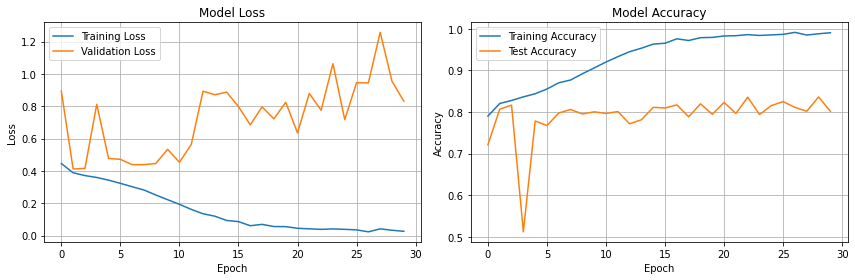

In [167]:
display_loss_accuracy(history7)

In [168]:
# printing the dataframe
train7_acc = history7.history['accuracy']
resultDF7 = createResult("DenseNet_model",train7_acc[-1],model7_test_acc)
resultDF7

,Method,Accuracy,Test Score
0,DenseNet_model,0.990516,0.800033


189/189 [==============================] - 7s 37ms/step
----------------------Confusion Matrix---------------------



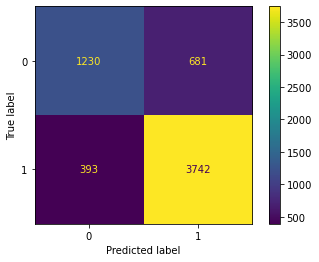



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.76      0.64      0.70      1911
           1       0.85      0.90      0.87      4135

    accuracy                           0.82      6046
   macro avg       0.80      0.77      0.79      6046
weighted avg       0.82      0.82      0.82      6046



-----------------------ROC Curve-----------------------



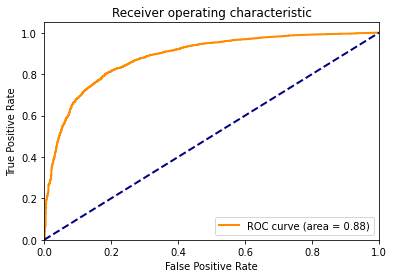

In [169]:
evaluate_model(inception_model, X_test, y_test)

In [170]:
# Predict from the test set
threshold = 0.5
# Predict from the test set
y_prob7 = model7.predict(x=X_test)
y_prob7 = y_prob7.reshape((len(y_prob7),))

# Convert to binary probabilities
y_hat7   = y_prob7 > threshold
y_hat7   = y_hat7.reshape(len(y_hat7),)

    
reportData = classification_report(y_test, y_hat7,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF7[data+"_"+subData] = reportData[data][subData]

resultDF7

2022-08-23 08:58:30.512416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 14s 53ms/step


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,DenseNet_model,0.990516,0.800033,0.895619,0.800967,0.845653,4135


In [206]:
df =pd.concat([resultDF1,resultDF2,resultDF3,resultDF4,resultDF5,resultDF6,resultDF7],ignore_index=True)
df

,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classes,0.827130,0.809792,0.834416,0.900605,0.866248,4135
1,CNN model with 3 classes,0.695230,0.623222,0.549363,0.583510,0.565922,2365
2,CNN model-1 with Augumentation,0.797960,0.805822,0.829659,0.901088,0.863900,4135
3,CNN_VGG16_model with trainable -False,0.826578,0.801522,0.830146,0.892382,0.860140,4135
4,CNN_VGG16_model with trainable -True,0.963606,0.818558,0.871394,0.861911,0.866626,4135
5,inception_base_model,0.888062,0.822362,0.846032,0.904958,0.874503,4135
6,DenseNet_model,0.990516,0.800033,0.895619,0.800967,0.845653,4135


In [160]:
model1.save('best_CNN_model1_final.h5')
model3.save('best_CNN_model3_final.h5')
CNN_VGG16_model.save('best_CNN_VGG16_model_final.h5')
inception_model.save('best_inception_model_final.h5')

#best_model.save('best_DenseNet_model_final.h5')

In [172]:
model7.save('best_DenseNet_model_final.h5')

In [173]:
#best_model = tf.keras.models.load_model('best_VGG16_model_trainable.h5')

In [207]:

round(df*100,2)


,Method,Accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN model with 2 classesCNN model with 2 class...,82.71,80.98,83.44,90.06,86.62,413500
1,CNN model with 3 classesCNN model with 3 class...,69.52,62.32,54.94,58.35,56.59,236500
2,CNN model-1 with AugumentationCNN model-1 with...,79.80,80.58,82.97,90.11,86.39,413500
3,CNN_VGG16_model with trainable -FalseCNN_VGG16...,82.66,80.15,83.01,89.24,86.01,413500
4,CNN_VGG16_model with trainable -TrueCNN_VGG16_...,96.36,81.86,87.14,86.19,86.66,413500
5,inception_base_modelinception_base_modelincept...,88.81,82.24,84.60,90.50,87.45,413500
6,DenseNet_modelDenseNet_modelDenseNet_modelDens...,99.05,80.00,89.56,80.10,84.57,413500


In [ ]:
# Insights of transfer learning and final conclusion:

# Among the CNN model with 2 classes (clubbed the classes of no lung opacity and normal) 
# and CNN model with 3 classes using stratify sampling (inorder to make sure of the same ratio of classes
# for modelling), it has been found that accuracy and recall of pnemonia class (class 1) are higher
# for model with 2 classes, so we have used 2 classes only for further analysis/modelling 

# then we have tried the CNN model (with 2 classes) after augumenting the images and this model has shown 
# slightly increase in recall percentage with relatively no change in test accuracy inspite of slight 
# decrease in train accuracy

# Later on we have tried with transfer learning models of VGG 16. Among the trainable- false and true,
# it has been observed that VGG 16 trainable -False has shown relatively higher accuracy when compared
# to VGG trainable- True.

# Further we have tried with inception net (Google net) and dense net. Dense net has given highest training
# accuracy among all the techniques but quites less recall percentage.

# Finally, it has been found that inception net is the best among all transfer learning models being tried 
# and has given highest recall percentage which is the main moto of this project since this belongs 
# to health care domain and need to focus on decreasing the false negative rate